# Generowanie danych symulujących jazdę platformy robotycznej

Ten dokument prezentuje i opisuje metody generacji danych imitujących dane zwracane przez czujniki przeznaczone do śledzenia trasy przebytej przez platformę robotyczną.
Te dane zostaną następnie użyte do zweryfikowania poprawności działania filtru Kalmana, oraz algorytmów mapujących je na trasę w formie punktów na płaszczyźnie dwuwymiarowej.

## Rodzaje badanych modułów

Badane będą dane z następujących modułów:

* Akcelerometr i żyroskop (MPU-6050)
* Enkoder wieloobrotowy (przymocowany do osi koła via przełożenie)
* Moduł optical-flow (ADNS3080)
* Kamera Intel RealSense T265

Dla każdego z modułów zostanie stworzony uproszczony model teoretyczny, pozwalający na generowanie danych z uwzględnieniem ich niedokładności.

Uwzględniane parametry (oraz domyślne wartości na podstawie danych z dokumentacji i testów znalezionych w internecie):

* Dla MPU-6050:
    * Zakładamy parametry czujnika przy temperaturze 25*C (ignorujemy dryft temperaturowy w celu uproszczenia modelu), przy warunkach określonych w datasheecie
    * Dla żyroskopu:
        * Full-Scale Range ($\text{FSR}$, $\text{[º/s]}$), pełny zakres pomiaru żyroskopu - od ±250º/s do ±2000º/s
        * Sensitivity Scale Factor ($\text{SSF}$, $\text{[LSB/(º/s)]}$), współczynnik czułości - 131 / 65.5 / 32.8 / 16.4 LSB/(º/s) przy FSR równym 250, 500, 1000 i 2000 º/s
        * Cross-Axis Sensitivity ($\text{CAS}$, $\text{[\%]}$), czułość międzyosiowa, przykładowo: wpływ ruchu w osi X oraz Z na odczyt z osi Y - 2%
        * Zero-Rate Output ($\text{ZRO}$, $\text{[º/s]}$), wartość wyjściowa przy braku ruchu - ±20º/s
        * Szum (błąd) względny pojedynczego pomiaru ($\delta$, $\text{[\%]}$): ±3%
        * Szum (błąd) bezwzględny pojedynczego pomiaru ($\Delta$, $\text{[deg/s-rms]}$): 0.05º/s-rms
    * Dla akcelerometru:
        * Full-Scale Range ($\text{FSR}$, $\text{[g]}$) - od ±2g do ±16g
        * Sensitivity Scale Factor ($\text{SSF}$, $\text{[LSB/g]}$) - 16384 / 8192 / 4096 / 2048 LSB/g przy FSR równym 2 / 4 / 8 / 16 g
        * Cross-Axis Sensitivity ($\text{CAS}$, $\text{[\%]}$) - 2%
        * Zero-Rate Output ($\text{ZRO}$, $\text{[mg]}$) - ±50 mg dla osi X i Y, ±80 mg dla osi Z
        * Szum (błąd) względny pojedynczego pomiaru ($\delta$, $\text{[\%]}$): ±3%
* Dla enkodera:
    * Częstotliwość pomiaru ($\text{f}$, $\text{[Hz]}$) - do ustalenia, wstępnie 50Hz
    * 400 kroków na obrót (Counts Per Turn, $\text{CPT}$)
    * Przełożenie $k = 3$ (ze względu na sposób montażu)
    * Błąd względny ($\delta$, $\text{[\%]}$) - 1%
* Dla ADNS3080:
    * Framerate - od 2000 do 6000 FPS
    * Rozdzielczość - od 400 do 1600 cpi (counts per inch)
    * Błąd bezwzględny ($\Delta$, $\text{[mc]}$ (mouse count)) - 5mc, w celu obliczenia dystansu należy podzielić tą wartość przez rozdzielczość
    * Błąd względny ($\delta$, $\text{[\%]}$) - 2%
    * Ze względu na nietypowe zastosowanie (czujnik jest przeznaczony m.in do myszek komputerowych), parametry z dokumentacji mogą nie być adekwatne do rzeczywistych parametrów uzyskanych w urządzeniu, będzie konieczna ręczna kalibracja.
* Dla Intel RealSense T265:
    * Błąd względny ($\delta$, $\text{[\%]}$) - 1%


## Symulacja MPU-6050 (akcelerometr i żyroskop)

MPU-6050 to cyfrowy 3-osiowy akcelerometr/żyroskop. Pomimo wykorzystania tylko 2 osi w badaniach (X oraz Y), oś Z również zostanie symulowana ze względu na CAS, które powoduje że teoretycznie zmiany w osi Z mogą wpływać na odczyty z osi X oraz Y. 

Zaczniemy od symulacji pojedynczej osi, z założeniem że dane zwracane przez moduł są idealne. Następnie zostaną dodane kolejne źródła zakłóceń z możliwością ich parametryzacji.

Załóżmy że dane generowane przez moduł mają rozkład jednostajny, a szumy i niedokładności będą miały rozkład normalny (Gaussa). Przykładowy kod generujący losową wartość z zakresu $[a, b)$ o rozkładzie jednostajnym można wygenerować w następujący sposób:

In [1]:
import numpy as np

a = 0
b = 10

generator = np.random.default_rng()
print(generator.uniform(a, b))


7.709500665973568


Generując losowe wartości nie otrzymamy danych przypominających te odczytane z czujnika podczas jazdy. Gdyby wartości które otrzymamy z takiego generatora zostały zmapowane na trasę, otrzymalibyśmy dużo losowych punktów skupionych wokół punktu startu. Potencjalnym rozwiązaniem tego problemu jest dodanie logiki do generatora, która będzie sterować zakresem generowanych wartości w zależności od założonego kierunku oraz przyspieszenia.

Podczas przyspieszania i zwalniania, przeciążenie powinno rosnąć a następnie maleć, proporcjonalnie do zmiany zakładanej szybkości pojazdu. Podczas jednostajnej jazdy, przyspieszenie powinno być niskie i powinny być widoczne zakłócenia związane z wibracjami i chwilowymi zmianami w szybkości pojazdu.

Mamy więc trzy możliwe scenariusze - przyspieszanie, zwalnianie oraz ruch jednostajny. Parametrami dla pierwszych dwóch powinna być szybkość startowa, szybkość docelowa i czas zmiany szybkości.

### Symulacja ruchu pojazdu

#### Symulacja jazdy (przyspieszanie, zwalnianie)

Zakładamy że przyspieszenie jest jednostajne. Zaczniemy od wygenerowania danych dotyczących aktualnej szybkości przyspieszenia w czasie, dodatkowo obliczając wartość przeciążenia które powinien zwrócić akcelerometr.

Amount of time points: 50
Acceleration: 0.40816326530612246
g-force: 0.4078864851911713


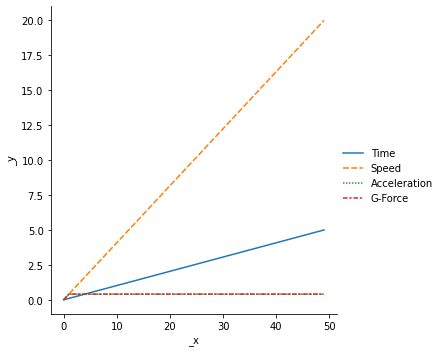

In [2]:
import pandas as pd
import seaborn as sns
from scipy.constants import g as g_constant


def calculate_g_force(
    start_speed: float, target_speed: float, acceleration_time: float
):
    return (target_speed - start_speed) / (acceleration_time * g_constant)


def generate_movement_data(
    start_speed: float, target_speed: float, acceleration_time: float, time_step: float
) -> pd.DataFrame:
    """Returns a dataframe with time points, speed, acceleration and g-force"""
    time_points_count = int(acceleration_time / time_step)
    if time_points_count <= 0:
        return pd.DataFrame()

    # Create an array with all the time points where measurements happened
    time_points = np.linspace(0, acceleration_time, time_points_count)
    # Map the time points to speed
    speed = np.array(
        [
            np.interp(time_point, [0, acceleration_time], [start_speed, target_speed])
            for time_point in time_points
        ]
    )
    # Calculate the acceleration and g-force
    acceleration = np.concatenate([np.array([0]), np.diff(speed)], axis=None)
    g_force = np.array(
        [0]
        + [calculate_g_force(start_speed, target_speed, acceleration_time)]
        * (len(time_points) - 1)
    )

    df_dict = {
        "Time": time_points,
        "Speed": speed,
        "Acceleration": acceleration,
        "G-Force": g_force,
    }

    return pd.DataFrame(df_dict)


# Assume acceleration from 0 to 20 m/s, in 5 seconds, with 0.1s measurement frequency
acceleration_data = generate_movement_data(0, 20, 5, 0.1)

print(f"Amount of time points: {len(acceleration_data.index)}")
print(f"Acceleration: {acceleration_data.iloc[1]['Acceleration']}")
print(f"g-force: {acceleration_data.iloc[1]['G-Force']}")

sns.relplot(data=acceleration_data, kind="line")


Funkcja zwraca cztery listy - technicznie te obliczenia można wykonać i zwrócić w formie pojedynczych wartości, ale wybrałem taką formę dla ułatwienia pakowania ich do `DataFrame`

Jak widać na powyższym wykresie, wygenerowane dane wyglądają prawidłowo - akceleracja jest stała, szybkość osiąga 20m/s a czas 5s. Zgadza się również częstotliwość pomiarów - mierząc dane przez 5 sekund z częstotliwością 10Hz otrzymujemy 50 próbek.
Można zastosować inny wzór na obliczanie przeciążenia - $\text{G force} = \frac{a}{g}$, gdzie $a$ to akceleracja w $\frac{m}{s^2}$, a $g$ to stała grawitacyjna.

Możemy użyć tego samego kodu do wygenerowania danych symulujących hamujący pojazd, co widoczne jest poniżej.

Amount of time points: 50
Acceleration: -0.408163265306122
g-force: -0.4078864851911713


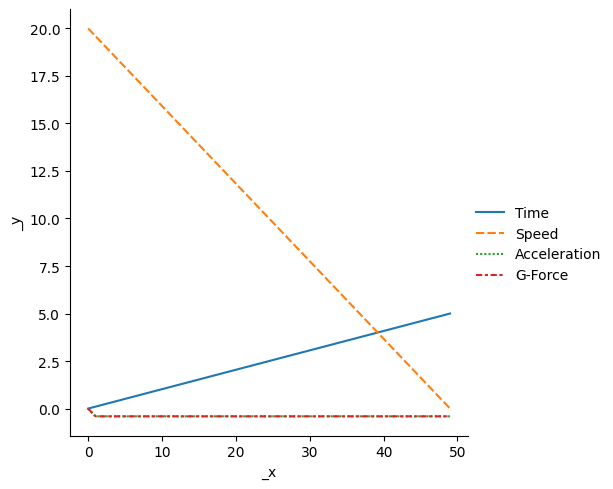

In [3]:
acceleration_data = generate_movement_data(20, 0, 5, 0.1)

print(f"Amount of time points: {len(acceleration_data.index)}")
print(f"Acceleration: {acceleration_data.iloc[1]['Acceleration']}")
print(f"g-force: {acceleration_data.iloc[1]['G-Force']}")

sns.relplot(data=acceleration_data, kind="line")


Możemy tą funkcję wykorzystać również do generowania ruchu jednostajnego:

Amount of time points: 50
Acceleration: 0.0
g-force: 0.0


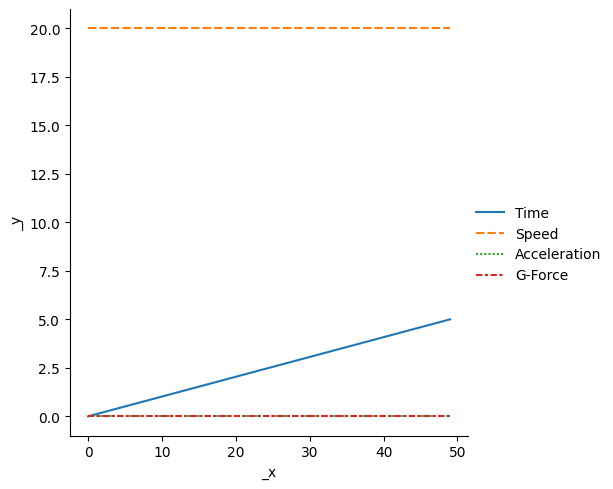

In [4]:
acceleration_data = generate_movement_data(20, 20, 5, 0.1)

print(f"Amount of time points: {len(acceleration_data.index)}")
print(f"Acceleration: {acceleration_data.iloc[1]['Acceleration']}")
print(f"g-force: {acceleration_data.iloc[1]['G-Force']}")

sns.relplot(data=acceleration_data, kind="line")


#### Symulacja obrotu

Poniżej przedstawiona jest funkcja która generuje dane dotyczące obrotu pojazdu o określoną ilość stopni w określonym czasie

Amount of time points: 50
Rotation speed: 1.0204081632653061


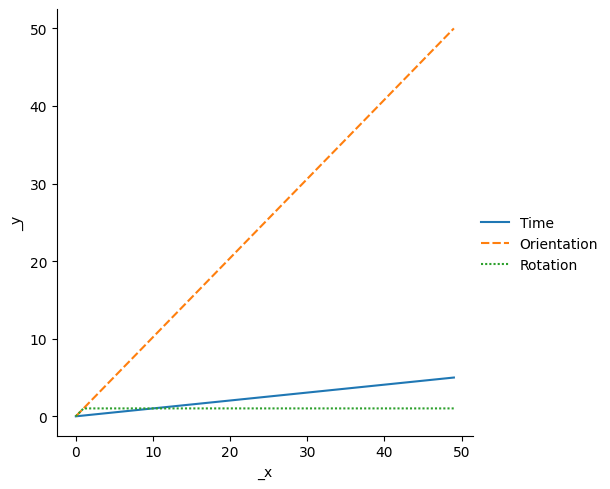

In [5]:
def generate_rotation_data(
    start_orientation: float,
    end_orientation: float,
    rotation_time: float,
    time_step: float,
) -> pd.DataFrame:
    """Returns a dataframe with time, orientation and rotation"""
    time_points_count = int(rotation_time / time_step)
    # Create an array with all the time points where measurements happened
    time_points = np.linspace(0, rotation_time, time_points_count)
    # Map the time points to orientation
    orientation = np.array(
        [
            np.interp(
                time_point, [0, rotation_time], [start_orientation, end_orientation]
            )
            for time_point in time_points
        ]
    )
    # Calculate the rotation for each time point
    rotation = np.concatenate([np.array([0]), np.diff(orientation)], axis=None)

    df_dict = {
        "Time": time_points,
        "Orientation": orientation,
        "Rotation": rotation,
    }

    return pd.DataFrame(df_dict)


rotation_data = generate_rotation_data(0, 50, 5, 0.1)

print(f"Amount of time points: {len(rotation_data.index)}")
print(f"Rotation speed: {rotation_data.iloc[1]['Rotation']}")

sns.relplot(data=rotation_data, kind="line")


Łatwo zauważyć, że powyższa funkcja do generowania ruchu obrotowego działa praktycznie tak samo jak funkcja do generowania ruchu po linii prostej. Następnym krokiem jest wykorzystanie powyższych funkcji do stworzenia modelu MPU-6050.

### Symulacja MPU-6050

MPU-6050 to trzyosiowy akcelerometr i żyroskop. Zaczniemy od stworzenia idealnych modeli 3-osiowych akcelerometrów i żyroskopów, z założeniem że ruch będzie odbywać się tylko na jednej osi (X) akcelerometru, oraz jednej osi (Z) żyroskopu. Wykorzystamy do tego stworzone wcześniej generatory danych. Modele wyposażymy w funkcje które będą umożliwiać konfigurację parametrów dostępnych w MPU-6050, czyli pełny zakres pomiaru (FSR) i częstotliwość samplingu (1kHz lub niższa, sterowana wartością dzielnika).

Poniższy rysunek przedstawia osie relatywnie do położenia akcelerometru i żyroskopu na łaziku.

![rover sim visualization](./img/rover_sim_visualization.png)

#### Model akcelerometru

Nasz testowy akcelerometr powinien generować dane dotyczące ruchu na podstawie przekazanej mu trasy przebytej przez łazika. Założymy że trasa składać się będzie z listy kolejnych punktów które łazik osiągnie i czasu który mu zajęło przebycie tych punktów. Szybkość łazika będzie obliczana na podstawie czasu przebycia drogi, z założeniem że będzie ona zmieniać się liniowo - nie będę dodawać funkcji wygładzających ani estymujących realistyczne zmiany szybkości na potrzeby symulacji, wygenerowanie odpowiednich punktów trasy powinno być wystarczające. 

Zakładamy warunki początkowe dla metody `simulate_3d_movement`:
* Pozycja - (0, 0, 0)
* Szybkość - (0, 0, 0)

Dla każdego punktu na trasie zostaje obliczona średnia szybkość wymagana do przebycia odcinka na podstawie różnicy odległości i czasu. Następnie, za pomocą funkcji `generate_movement_data` zostaje stworzona ramka z danymi dotyczącymi przebytego ruchu. Wygenerowane w ten sposób ramki danych są sumowane i zostają zwrócone z funkcji.

In [8]:
from enum import Enum, unique, auto
import pandas as pd
from typing import Tuple


def calculate_frequency_divider(base_frequency: float, target_frequency: int) -> int:
    return round(base_frequency / target_frequency)  # lmao verbosity much


class Accelerometer3D:
    @unique
    class FullRange(Enum):
        """'R' in enum values is prefix abbreviation from "Range", added since names can't start with a number"""

        R2G = auto()
        R4G = auto()
        R8G = auto()
        R16G = auto()

    def __init__(self, range: FullRange = FullRange.R4G, divider: int = 10):
        self._full_range: self.FullRange = range
        self._divider: int = divider
        self._base_frequency: int = 1000

    def simulate_single_axis_movement(
        self, start_speed: float, start_point: int, end_point: int, time: float
    ) -> Tuple[pd.DataFrame, float, float]:
        distance: int = end_point - start_point
        average_speed: float = float(distance) / time
        end_speed: float = 2.0 * average_speed - start_speed
        time_step = self.divider / self.base_frequency

        print(
            f"distance = {distance}, start speed = {start_speed}, avg speed = {average_speed}, end speed = {end_speed}, time step = {time_step}"
        )
        movement_data = generate_movement_data(
            start_speed, end_speed, time, time_step
        )

        print(movement_data)

        return movement_data, average_speed, end_speed

    def simulate_3d_movement(
        self,
        path: pd.DataFrame,
        starting_point: Tuple[int, int, int] = (0, 0, 0),
        starting_speed: Tuple[float, float, float] = (0.0, 0.0, 0.0),
    ):
        """This function returns a dataframe with generated accelerometer data of movement between all the points specified in `path_points`.

        `path_points` is a dataframe which should contain `x`, `y`, 'z', and `time` columns. Generated dataframe will contain accelerometer data generated for all paths
        between points, traveled in specified time. Origin position is assumed to be (0, 0, 0), and starting speed is assumed to be (0, 0, 0).

        All axes are relative to the accelerometer position and orientation. In typical scenario, when mounted on a rover, it's fixed to rover's position and orientation,
        hence the movement forward and backwards should always be detected on "Y" axis, like seen on picture above this code block. Make sure to remember that when passing
        the coordinates to this function - for driving robotic platform, no significant movement on "X" or "Z" axes should be detected when driving in a straight line.

        Because of that, if you want to simulate a path with turns, the recommended way of doing so is assuming that rover turns only when it's stopped and generating the
        path points accordingly, while also converting the points from global coordinate space to one relative to accelerometer position."""

        current_point = list(starting_point)
        current_speed = list(starting_speed)

        for index, row in path.iterrows():
            print(f"x: {row['x']}, y: {row['y']}, z: {row['z']}, time: {row['time']}")
            (
                movement_y,
                average_speed_y,
                end_speed_y,
            ) = self.simulate_single_axis_movement(
                current_speed[1], current_point[1], row["y"], row["time"]
            )

            current_point[1] = row["y"]
            current_speed[1] = end_speed_y

            print('=====')

    @property
    def full_range(self) -> FullRange:
        return self._full_range

    @property
    def divider(self) -> int:
        return self._divider

    @property
    def base_frequency(self) -> int:
        return self._base_frequency

    @full_range.setter
    def full_range(self, value: FullRange):
        if isinstance(value, self.FullRange):
            self._full_range = value

    @divider.setter
    def divider(self, value: int):
        value = int(
            value
        )  # double-check to make sure we're not trying to do anything stupid
        if value >= 1 and value <= 1000:
            self._divider = value


path_data = pd.DataFrame(
    {
        "x": [0, 0, 0, 0, 0],
        "y": [10, 50, 30, -20, 0],
        "z": [0, 0, 0, 0, 0],
        "time": [10, 5, 20, 12, 8],
    }
)

accel = Accelerometer3D()

print(accel.simulate_3d_movement(path_data))


x: 0, y: 10, z: 0, time: 10
distance = 10, start speed = 0.0, avg speed = 1.0, end speed = 2.0, time step = 0.01
         Time     Speed  Acceleration   G-Force
0     0.00000  0.000000      0.000000  0.000000
1     0.01001  0.002002      0.002002  0.020394
2     0.02002  0.004004      0.002002  0.020394
3     0.03003  0.006006      0.002002  0.020394
4     0.04004  0.008008      0.002002  0.020394
..        ...       ...           ...       ...
995   9.95996  1.991992      0.002002  0.020394
996   9.96997  1.993994      0.002002  0.020394
997   9.97998  1.995996      0.002002  0.020394
998   9.98999  1.997998      0.002002  0.020394
999  10.00000  2.000000      0.002002  0.020394

[1000 rows x 4 columns]
=====
x: 0, y: 50, z: 0, time: 5
distance = 40, start speed = 2.0, avg speed = 8.0, end speed = 14.0, time step = 0.01
        Time      Speed  Acceleration   G-Force
0    0.00000   2.000000      0.000000  0.000000
1    0.01002   2.024048      0.024048  0.244732
2    0.02004   2.048096